<a href="https://colab.research.google.com/github/lawrencejesse/Sentinel2_Extractor/blob/main/Reclamation_Analysis_AEFv4_working.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup and Authentication

In [1]:
# Import required libraries
import ee
import geemap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
import ipywidgets as widgets
from IPython.display import display, HTML
import json
import os
from io import BytesIO
import zipfile

In [2]:
# Authenticate and initialize Earth Engine
# Change 'jessemapping' to your Earth Engine project ID if needed
print("Authenticating with Earth Engine...")
ee.Authenticate()
ee.Initialize(project="jessemapping")
print("✓ Earth Engine initialized successfully")

Authenticating with Earth Engine...
✓ Earth Engine initialized successfully


In [3]:
%pip install fiona geopandas

## 1. Upload Boundary Files

Upload your polygon files (KML, GeoJSON, or SHP/ZIP):
- **Field Boundary:** The clean agricultural area (quarter section minus non-arable areas)
- **Lease Boundary:** The disturbed oilfield lease site

In [43]:
# Store uploaded geometries
field_boundary = None
lease_boundary = None

def parse_file(content, filename, name):
    """Parse uploaded file and return Earth Engine geometry"""
    temp_path = f'/tmp/{filename}'
    os.makedirs('/tmp', exist_ok=True)

    with open(temp_path, 'wb') as f:
        f.write(content)

    try:
        if filename.endswith('.kml'):
            import fiona
            fiona.drvsupport.supported_drivers['KML'] = 'r'
            import geopandas as gpd
            gdf = gpd.read_file(temp_path, driver='KML')
        elif filename.endswith(('.geojson', '.json')):
            import geopandas as gpd
            gdf = gpd.read_file(temp_path)
        elif filename.endswith('.zip'):
            with zipfile.ZipFile(temp_path, 'r') as zip_ref:
                zip_ref.extractall('/tmp/shp_extract')
            shp_file = None
            for root, dirs, files in os.walk('/tmp/shp_extract'):
                for file in files:
                    if file.endswith('.shp'):
                        shp_file = os.path.join(root, file)
                        break
                if shp_file:
                    break
            if shp_file:
                import geopandas as gpd
                gdf = gpd.read_file(shp_file)
            else:
                raise ValueError("No .shp file found in the uploaded zip archive.")
        elif filename.endswith('.shp'):
            import geopandas as gpd
            gdf = gpd.read_file(temp_path)
        else:
            raise ValueError(f"Unsupported file format: {filename}")

        # Ensure WGS84 projection
        if gdf.crs and gdf.crs.to_string() != 'EPSG:4326':
            gdf = gdf.to_crs('EPSG:4326')

        # Convert to GeoJSON
        geojson = json.loads(gdf.to_json())

        if geojson['features']:
            geometry = geojson['features'][0]['geometry']
            ee_geom = ee.Geometry(geometry)
            # Simplify geometry with a larger error margin to fix potential topological issues
            ee_geom = ee_geom.simplify(ee.ErrorMargin(10)) # Increased error margin to 10 meters
            print(f"✓ {name} parsed successfully from {filename}")
            return ee_geom
        else:
            raise ValueError(f"No features found in {filename}")

    except Exception as e:
        print(f"✗ Error processing {name} file '{filename}': {str(e)}")
        return None
    finally:
        if os.path.exists(temp_path):
            os.remove(temp_path)
        if os.path.exists('/tmp/shp_extract'):
            import shutil
            shutil.rmtree('/tmp/shp_extract')

def upload_files():
    global field_boundary, lease_boundary
    from google.colab import files

    print("Please upload your Field Boundary file (KML, GeoJSON, SHP/ZIP)...")
    uploaded = files.upload()

    for filename, content in uploaded.items():
        field_boundary = parse_file(content, filename, "Field Boundary")
        break

    print("\nPlease upload your Lease Boundary file (KML, GeoJSON, SHP/ZIP)...")
    uploaded = files.upload()

    for filename, content in uploaded.items():
        lease_boundary = parse_file(content, filename, "Lease Boundary")
        break

    if field_boundary and lease_boundary:
        print("\n✓ Both boundaries loaded successfully!")
    else:
        print("\n✗ Error processing files. Check the messages above.")

upload_files()

Please upload your Field Boundary file (KML, GeoJSON, SHP/ZIP)...


Saving 6-14Field.kml to 6-14Field.kml
✓ Field Boundary parsed successfully from 6-14Field.kml

Please upload your Lease Boundary file (KML, GeoJSON, SHP/ZIP)...


Saving 6-14LeaseOnly.kml to 6-14LeaseOnly.kml
✓ Lease Boundary parsed successfully from 6-14LeaseOnly.kml

✓ Both boundaries loaded successfully!


## 2. Configure Analysis Years

Select which years you want to analyze.

In [44]:
# Configure analysis years - modify as needed
# AlphaEarth Foundation data is available from 2017 onwards
ANALYSIS_YEARS = list(range(2017, 2024))  # 2017 to 2023

print(f"Years to analyze: {ANALYSIS_YEARS}")
print(f"\nNote: AlphaEarth Foundation data is available from 2017 onwards.")

Years to analyze: [2017, 2018, 2019, 2020, 2021, 2022, 2023]

Note: AlphaEarth Foundation data is available from 2017 onwards.


## 3. Extract Crop History (AAFC Annual Crop Inventory)

Identify what crop was grown in the field for each year.

In [45]:
# AAFC crop classification lookup
CROP_CLASSES = {
    10: 'Cloud',
    20: 'Water',
    30: 'Exposed Land and Barren',
    34: 'Urban and Developed',
    35: 'Greenhouses',
    50: 'Shrubland',
    80: 'Wetland',
    85: 'Peatland',
    110: 'Grassland',
    120: 'Agriculture (undifferentiated)',
    122: 'Pasture and Forages',
    130: 'Too Wet to be Seeded',
    131: 'Fallow',
    132: 'Cereals',
    133: 'Barley',
    134: 'Other Grains',
    135: 'Millet',
    136: 'Oats',
    137: 'Rye',
    138: 'Spelt',
    139: 'Triticale',
    140: 'Wheat',
    141: 'Switchgrass',
    142: 'Sorghum',
    143: 'Quinoa',
    145: 'Winter Wheat',
    146: 'Spring Wheat',
    147: 'Corn',
    148: 'Tobacco',
    149: 'Ginseng',
    150: 'Oilseeds',
    151: 'Borage',
    152: 'Camelina',
    153: 'Canola and Rapeseed',
    154: 'Flaxseed',
    155: 'Mustard',
    156: 'Safflower',
    157: 'Sunflower',
    158: 'Soybeans',
    160: 'Pulses',
    161: 'Other Pulses',
    162: 'Peas',
    163: 'Chickpeas',
    167: 'Beans',
    168: 'Fababeans',
    174: 'Lentils',
    175: 'Vegetables',
    176: 'Tomatoes',
    177: 'Potatoes',
    178: 'Sugarbeets',
    179: 'Other Vegetables',
    180: 'Fruits',
    181: 'Berries',
    182: 'Blueberry',
    183: 'Cranberry',
    185: 'Other Berry',
    188: 'Orchards',
    189: 'Other Fruits',
    190: 'Vineyards',
    191: 'Hops',
    192: 'Sod',
    193: 'Herbs',
    194: 'Nursery',
    195: 'Buckwheat',
    196: 'Canaryseed',
    197: 'Hemp',
    198: 'Vetch',
    199: 'Other Crops',
    200: 'Forest (undifferentiated)',
    210: 'Coniferous',
    220: 'Broadleaf',
    230: 'Mixedwood'
}

def get_crop_history(geometry, years, scale=30, sample_size=500):
    """
    Extract the most frequent crop type within a geometry for each year.
    """
    aafc = ee.ImageCollection('AAFC/ACI')
    allowed_codes = list(CROP_CLASSES.keys())
    crop_history = {}

    for year in years:
        crop_img = aafc.filter(ee.Filter.date(f'{year}-01-01', f'{year}-12-31')).first()

        if crop_img:
            samples = crop_img.select('landcover').sample(
                region=geometry,
                scale=scale,
                numPixels=sample_size,
                seed=year,
                geometries=False
            )

            sample_list = samples.aggregate_array('landcover').getInfo()
            filtered_samples = [code for code in sample_list if code in allowed_codes]

            if filtered_samples:
                from collections import Counter
                code_counts = Counter(filtered_samples)
                most_common = code_counts.most_common(1)

                if most_common:
                    crop_code = most_common[0][0]
                    crop_name = CROP_CLASSES.get(crop_code, f'Unknown ({crop_code})')
                    crop_history[year] = {'code': crop_code, 'name': crop_name}
                else:
                    crop_history[year] = {'code': None, 'name': 'No Valid Crop Found'}
            else:
                print(f"Warning: No sampled pixels had an allowed crop code for year {year}.")
                crop_history[year] = {'code': None, 'name': 'No Allowed Crop Sampled'}

    return crop_history

print("✓ Crop history extraction function ready")

✓ Crop history extraction function ready


In [46]:
# Extract crop history for the field
if field_boundary:
    print("Extracting crop history from AAFC Annual Crop Inventory...")
    crop_history = get_crop_history(field_boundary, ANALYSIS_YEARS)

    print("\nCrop History:")
    crop_df = pd.DataFrame.from_dict(crop_history, orient='index')
    crop_df.index.name = 'Year'
    display(crop_df)
else:
    print("Please upload field boundaries first.")

Extracting crop history from AAFC Annual Crop Inventory...

Crop History:


,code,name
Year,,
2017,146,Spring Wheat
2018,153,Canola and Rapeseed
2019,146,Spring Wheat
2020,153,Canola and Rapeseed
2021,146,Spring Wheat
2022,153,Canola and Rapeseed
2023,146,Spring Wheat


## 4. AlphaEarth Foundation Embedding Extraction

This is the core analysis section. Key features:
- **Correct band naming:** Uses A00-A63 format (not embedding_0-63)
- **AOI intersection:** Clips geometries to valid image coverage
- **Null handling:** Gracefully handles edge pixels with no data

In [47]:
# Initialize AlphaEarth Foundation collection
aef_collection = ee.ImageCollection("GOOGLE/SATELLITE_EMBEDDING/V1/ANNUAL")

# IMPORTANT: AlphaEarth bands are named A00-A63 (not embedding_0-63)
AEF_BAND_NAMES = [f'A{i:02d}' for i in range(64)]

print(f"AlphaEarth band names: {AEF_BAND_NAMES[:5]}... to ...{AEF_BAND_NAMES[-3:]}")
print(f"Total bands: {len(AEF_BAND_NAMES)}")

AlphaEarth band names: ['A00', 'A01', 'A02', 'A03', 'A04']... to ...['A61', 'A62', 'A63']
Total bands: 64


In [49]:
def get_embeddings(geometry, year, scale=10, min_pixels=10):
    """
    Extract mean 64D embedding for a geometry and year.
    Uses selfMask() to automatically exclude null/masked pixels.

    Args:
        geometry: ee.Geometry
        year: int (2017-2024)
        scale: int (default 10m)
        min_pixels: int (minimum valid pixels required, default 10)

    Returns:
        dict with 'embedding' (64D array or None), 'pixel_count', 'year', and 'status'
    """
    # Filter to specific year AND BOUNDS OF THE GEOMETRY
    aef_filtered = aef_collection.filter(ee.Filter.date(f'{year}-01-01', f'{year}-12-31')).filterBounds(geometry)

    # Check if any images exist for this year
    try:
        image_count = aef_filtered.size().getInfo()
    except Exception as e:
        print(f"    ERROR checking image count: {e}")
        return {
            'embedding': None,
            'pixel_count': 0,
            'year': year,
            'status': 'error'
        }

    if image_count == 0:
        print(f"    WARNING: No AlphaEarth images found for year {year} within the geometry bounds")
        return {
            'embedding': None,
            'pixel_count': 0,
            'year': year,
            'status': 'no_data'
        }

    aef_year = aef_filtered.first()

    # --- NEW DEBUG START (Geometry and Image CRS/Bounds) ---
    try:
        print(f"    DEBUG: Geometry CRS: {geometry.projection().getInfo()}")
        print(f"    DEBUG: AEF Image CRS: {aef_year.projection().getInfo()['crs']}")
        print(f"    DEBUG: Geometry bounds: {geometry.bounds().getInfo()['coordinates']}")
        print(f"    DEBUG: AEF Image bounds: {aef_year.geometry().bounds().getInfo()['coordinates']}")
    except Exception as geo_debug_e:
        print(f"    DEBUG: Error getting geometry/image debug info: {geo_debug_e}")
    # --- NEW DEBUG END ---

    # Clip the image to the geometry before selecting bands and reducing.
    # This ensures that we only operate on the part of the image that overlaps the geometry.
    aef_clipped = aef_year.clip(geometry)

    # --- DEBUG START --- (pixel count before selfMask)
    try:
        # Check if the clipped image has any raw pixels before selfMask
        raw_pixel_check = aef_clipped.select('A00').reduceRegion(
            reducer=ee.Reducer.count(),
            geometry=geometry,
            scale=scale,
            maxPixels=1e9,
            bestEffort=True
        ).getInfo()
        raw_pixel_count = raw_pixel_check.get('A00', 0)
        print(f"    DEBUG: Pixel count after clip (before selfMask): {raw_pixel_count}")

        # Check if the clipped and masked image has any valid pixels at all
        # Using an initial reduceRegion on just one band to check for any pixel data
        # Select the correct bands (A00-A63) and apply selfMask
        aef_selected_for_debug = aef_clipped.select(AEF_BAND_NAMES).selfMask()

        initial_pixel_check = aef_selected_for_debug.select('A00').reduceRegion(
            reducer=ee.Reducer.count(),
            geometry=geometry,
            scale=scale,
            maxPixels=1e9,
            bestEffort=True
        ).getInfo()
        debug_pixel_count = initial_pixel_check.get('A00', 0)
        print(f"    DEBUG: Pixel count after clip and selfMask (initial check): {debug_pixel_count}")

        # Get bounds of the clipped and masked image
        if debug_pixel_count > 0:
            try:
                image_bounds = aef_selected_for_debug.geometry().bounds().getInfo()
                print(f"    DEBUG: Clipped image bounds: {image_bounds['coordinates']}")
            except Exception as b_e:
                print(f"    DEBUG: Could not get clipped image bounds: {b_e}")
        else:
            print("    DEBUG: No pixels found after selfMask, so no clipped image bounds to report.")

    except Exception as d_e:
        print(f"    DEBUG: Error during debug pixel count check: {d_e}")
    # --- DEBUG END ---

    # Select the correct bands (A00-A63) and apply selfMask
    # selfMask() ensures we only use valid pixels (ignores masked/null areas)
    aef_selected = aef_clipped.select(AEF_BAND_NAMES).selfMask()

    # Compute mean embedding across the geometry
    # The selfMask ensures null pixels are excluded automatically
    try:
        stats = aef_selected.reduceRegion(
            reducer=ee.Reducer.mean().combine(
                reducer2=ee.Reducer.count(),
                sharedInputs=True
            ),
            geometry=geometry,
            scale=scale,
            maxPixels=1e9,
            bestEffort=True
        )
        result = stats.getInfo()
    except Exception as e:
        print(f"    ERROR in reduceRegion: {e}")
        return {
            'embedding': None,
            'pixel_count': 0,
            'year': year,
            'status': 'reduce_failed'
        }

    if not result:
        print(f"    WARNING: Empty result from reduceRegion for year {year}")
        return {
            'embedding': None,
            'pixel_count': 0,
            'year': year,
            'status': 'reduce_failed'
        }

    # Get pixel count first
    pixel_count = result.get('A00_count', None)
    if pixel_count is not None:
        try:
            pixel_count = int(pixel_count)
        except (TypeError, ValueError):
            pixel_count = 0
    else:
        pixel_count = 0

    print(f"    DEBUG: Final pixel count from reduceRegion for year {year}: {pixel_count}")

    # Check if we have enough valid pixels
    if pixel_count < min_pixels:
        print(f"    WARNING: Only {pixel_count} valid pixels (need at least {min_pixels}) for year {year}")
        return {
            'embedding': None,
            'pixel_count': pixel_count,
            'year': year,
            'status': 'insufficient_pixels'
        }

    # Extract embedding values with proper type handling
    embedding_values = []
    null_count = 0
    for i in range(64):
        val = result.get(f'A{i:02d}_mean', None)
        if val is None:
            embedding_values.append(0.0)
            null_count += 1
        else:
            try:
                embedding_values.append(float(val))
            except (TypeError, ValueError):
                embedding_values.append(0.0)
                null_count += 1

    # Check if too many null values in embedding
    if null_count > 32:  # More than half the bands are null
        print(f"    WARNING: {null_count}/64 bands returned null for year {year}")
        return {
            'embedding': None,
            'pixel_count': pixel_count,
            'year': year,
            'status': 'partial_data'
        }

    embedding = np.array(embedding_values, dtype=np.float64)

    # Final validation: check embedding is not all zeros
    if np.all(embedding == 0):
        print(f"    WARNING: All-zero embedding for year {year}")
        return {
            'embedding': None,
            'pixel_count': pixel_count,
            'year': year,
            'status': 'zero_embedding'
        }

    # Success!
    return {
        'embedding': embedding,
        'pixel_count': pixel_count,
        'year': year,
        'status': 'success'
    }

## 5. Run Reclamation Analysis

Compare lease embeddings to background field embeddings over time.

In [50]:
# Run the reclamation analysis
if field_boundary and lease_boundary and crop_history:
    print("Running reclamation analysis...")
    print("Comparing lease area to background field (field minus lease)\n")

    results = []

    # Calculate background area (field minus lease)
    # This represents the healthy/undisturbed reference within the same field
    background_area = field_boundary.difference(lease_boundary)

    # Get area info
    try:
        field_area_ha = field_boundary.area(10).divide(10000).getInfo()
        lease_area_ha = lease_boundary.area(10).divide(10000).getInfo()
        background_area_ha = background_area.area(10).divide(10000).getInfo()

        print(f"Field area: {field_area_ha:.2f} hectares")
        print(f"Lease area: {lease_area_ha:.2f} hectares")
        print(f"Background area: {background_area_ha:.2f} hectares\n")
    except Exception as e:
        print(f"Could not calculate areas: {e}\n")

    for year in sorted(crop_history.keys()):
        crop_info = crop_history[year]
        print(f"\nProcessing {year} - {crop_info['name']}...")

        try:
            # Extract embeddings for lease area
            print("  - Extracting lease embeddings...")
            lease_emb = get_embeddings(lease_boundary, year, scale=30, min_pixels=1)
            print(f"    Status: {lease_emb['status']}, Pixels: {lease_emb['pixel_count']}")

            # Extract embeddings for background (field minus lease)
            print("  - Extracting background embeddings...")
            background_emb = get_embeddings(background_area, year, scale=30, min_pixels=1)
            print(f"    Status: {background_emb['status']}, Pixels: {background_emb['pixel_count']}")

            # Check if we have valid embeddings for both
            if lease_emb['status'] != 'success' or background_emb['status'] != 'success':
                print(f"  ⚠ Skipping {year}: insufficient valid pixels")
                continue

            # Compute similarity between lease and background
            similarity = cosine_similarity(lease_emb['embedding'], background_emb['embedding'])
            distance = euclidean_distance(lease_emb['embedding'], background_emb['embedding'])

            results.append({
                'year': year,
                'crop': crop_info['name'],
                'crop_code': crop_info['code'],
                'lease_pixels': lease_emb['pixel_count'],
                'background_pixels': background_emb['pixel_count'],
                'cosine_similarity': similarity,
                'euclidean_distance': distance,
                'recovery_score': similarity,
                'recovery_percent': similarity * 100
            })

            print(f"  ✓ Cosine Similarity (Lease vs Background): {similarity:.4f}")
            print(f"  ✓ Euclidean Distance: {distance:.2f}")
            print(f"  ✓ Recovery Score: {similarity:.2%}")

        except Exception as e:
            print(f"  ✗ Error: {str(e)}")
            import traceback
            traceback.print_exc()
            continue

    # Create results DataFrame
    results_df = pd.DataFrame(results)

    print("\n" + "="*80)
    print("ANALYSIS COMPLETE")
    print("="*80)

    if len(results_df) > 0:
        print("\nRecovery scores show how similar the lease is to the healthy field background:")
        print("• 90-100%: Excellent recovery - lease performing like healthy field")
        print("• 80-90%: Good recovery - minor differences from field")
        print("• 70-80%: Moderate recovery - noticeable differences")
        print("• <70%: Poor recovery - significant differences from field\n")
        display(results_df)
    else:
        print("\nNo successful analyses completed. Please check the messages above.")
else:
    print("Please complete all previous steps first.")

Running reclamation analysis...
Comparing lease area to background field (field minus lease)

Field area: 102.65 hectares
Lease area: 1.43 hectares
Background area: 101.22 hectares


Processing 2017 - Spring Wheat...
  - Extracting lease embeddings...
    DEBUG: Geometry CRS: {'type': 'Projection', 'crs': 'EPSG:4326', 'transform': [1, 0, 0, 0, 1, 0]}
    DEBUG: AEF Image CRS: EPSG:32614
    DEBUG: Geometry bounds: [[[-101.839676320157, 50.33074418077088], [-101.837989660063, 50.33074418077088], [-101.837989660063, 50.33182381306542], [-101.839676320157, 50.33182381306542], [-101.839676320157, 50.33074418077088]]]
    DEBUG: Error getting geometry/image debug info: Geometry.bounds: Unable to perform this geometry operation. Please specify a non-zero error margin.
    DEBUG: Pixel count after clip (before selfMask): 16
    DEBUG: Pixel count after clip and selfMask (initial check): 16
    DEBUG: Clipped image bounds: [[[-101.839676320157, 50.33074418077088], [-101.837989660063, 50.330744

,year,crop,crop_code,lease_pixels,background_pixels,cosine_similarity,euclidean_distance,recovery_score,recovery_percent
0,2017,Spring Wheat,146,22,1180,0.904617,0.297720,0.904617,90.461719
1,2018,Canola and Rapeseed,153,18,1029,0.980625,0.139217,0.980625,98.062489
2,2019,Spring Wheat,146,22,1191,0.986807,0.109128,0.986807,98.680746
3,2020,Canola and Rapeseed,153,22,1201,0.987709,0.110679,0.987709,98.770872
4,2021,Spring Wheat,146,22,1164,0.977558,0.139138,0.977558,97.755778
5,2022,Canola and Rapeseed,153,20,598,0.982790,0.129185,0.982790,98.278958
6,2023,Spring Wheat,146,22,1110,0.986485,0.111992,0.986485,98.648526


## 6. Visualize Results

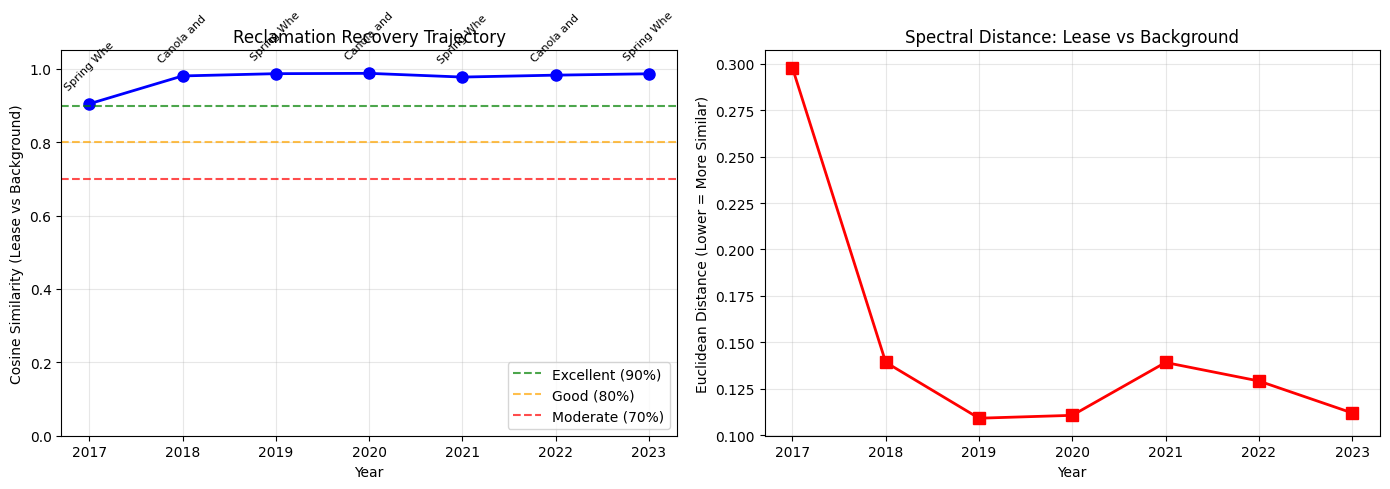


Summary Statistics:
  Mean Cosine Similarity: 0.9724
  Min Cosine Similarity: 0.9046 (2017)
  Max Cosine Similarity: 0.9877 (2020)

  Trend: Recovery appears to be improving
    Early period average: 0.9573
    Later period average: 0.9836


In [51]:
# Plot recovery trajectory over time
if 'results_df' in dir() and len(results_df) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Plot 1: Cosine Similarity over time
    ax1 = axes[0]
    ax1.plot(results_df['year'], results_df['cosine_similarity'], 'b-o', linewidth=2, markersize=8)
    ax1.axhline(y=0.9, color='g', linestyle='--', alpha=0.7, label='Excellent (90%)')
    ax1.axhline(y=0.8, color='orange', linestyle='--', alpha=0.7, label='Good (80%)')
    ax1.axhline(y=0.7, color='r', linestyle='--', alpha=0.7, label='Moderate (70%)')
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Cosine Similarity (Lease vs Background)')
    ax1.set_title('Reclamation Recovery Trajectory')
    ax1.legend(loc='lower right')
    ax1.set_ylim(0, 1.05)
    ax1.grid(True, alpha=0.3)

    # Add crop labels
    for idx, row in results_df.iterrows():
        ax1.annotate(row['crop'][:10], (row['year'], row['cosine_similarity']),
                    textcoords="offset points", xytext=(0,10), ha='center', fontsize=8, rotation=45)

    # Plot 2: Euclidean Distance over time
    ax2 = axes[1]
    ax2.plot(results_df['year'], results_df['euclidean_distance'], 'r-s', linewidth=2, markersize=8)
    ax2.set_xlabel('Year')
    ax2.set_ylabel('Euclidean Distance (Lower = More Similar)')
    ax2.set_title('Spectral Distance: Lease vs Background')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Summary statistics
    print("\nSummary Statistics:")
    print(f"  Mean Cosine Similarity: {results_df['cosine_similarity'].mean():.4f}")
    print(f"  Min Cosine Similarity: {results_df['cosine_similarity'].min():.4f} ({results_df.loc[results_df['cosine_similarity'].idxmin(), 'year']})")
    print(f"  Max Cosine Similarity: {results_df['cosine_similarity'].max():.4f} ({results_df.loc[results_df['cosine_similarity'].idxmax(), 'year']})")

    # Trend analysis
    if len(results_df) > 2:
        first_half = results_df['cosine_similarity'][:len(results_df)//2].mean()
        second_half = results_df['cosine_similarity'][len(results_df)//2:].mean()
        trend = "improving" if second_half > first_half else "declining" if second_half < first_half else "stable"
        print(f"\n  Trend: Recovery appears to be {trend}")
        print(f"    Early period average: {first_half:.4f}")
        print(f"    Later period average: {second_half:.4f}")
else:
    print("No results to visualize. Run the analysis first.")

## 7. Display Map

In [53]:
# Create interactive map with boundaries
if field_boundary and lease_boundary:
    # Get center point for map
    center = field_boundary.centroid().coordinates().getInfo()

    Map = geemap.Map(center=[center[1], center[0]], zoom=15)
    Map.add_basemap('Esri.WorldImagery') # Add Esri World Imagery basemap for satellite view

    # Add field boundary (green)
    Map.addLayer(
        field_boundary,
        {'color': '00FF00', 'fillColor': '00FF0022'},
        'Field Boundary'
    )

    # Add lease boundary (red)
    Map.addLayer(
        lease_boundary,
        {'color': 'FF0000', 'fillColor': 'FF000044'},
        'Lease Boundary'
    )

    # Add background area (blue) - field minus lease
    background_area = field_boundary.difference(lease_boundary)
    Map.addLayer(
        background_area,
        {'color': '0000FF', 'fillColor': '0000FF22'},
        'Background (Field - Lease)'
    )

    # Add an AlphaEarth Foundation image for visual inspection
    # Using the first year from ANALYSIS_YEARS for example
    aef_collection = ee.ImageCollection("GOOGLE/SATELLITE_EMBEDDING/V1/ANNUAL")
    first_analysis_year = ANALYSIS_YEARS[0]
    aef_image = aef_collection.filter(ee.Filter.date(f'{first_analysis_year}-01-01', f'{first_analysis_year}-12-31')).first()

    if aef_image:
        # Before adding the layer, try to get actual min/max values within the field boundary
        # This will help diagnose if there's data and how to visualize it
        try:
            stats = aef_image.select('A00').reduceRegion(
                reducer=ee.Reducer.minMax(),
                geometry=field_boundary,
                scale=10,
                maxPixels=1e9,
                bestEffort=True
            ).getInfo()
            actual_min = stats.get('A00_min')
            actual_max = stats.get('A00_max')
            print(f"AlphaEarth A00 band (within field boundary) for {first_analysis_year}: Min={actual_min}, Max={actual_max}")

            # Adjust vis_params based on actual min/max if they are not None
            if actual_min is not None and actual_max is not None:
                # Add a small buffer to min/max for better visualization, if values are close or zero
                min_val = actual_min - abs(actual_min * 0.1) if actual_min != 0 else -1
                max_val = actual_max + abs(actual_max * 0.1) if actual_max != 0 else 1
                if min_val == max_val:
                    min_val -= 0.5
                    max_val += 0.5

                vis_params_adjusted = {
                    'bands': ['A00'],
                    'min': min_val,
                    'max': max_val,
                    'gamma': 1.5
                }
                Map.addLayer(
                    aef_image.select('A00'),
                    vis_params_adjusted,
                    f'AlphaEarth A00 ({first_analysis_year}) (Adjusted Viz)'
                )
            else:
                print(f"Warning: Could not get min/max for A00 band within field boundary for {first_analysis_year}. Adding with default vis_params.")
                Map.addLayer(
                    aef_image.select('A00'),
                    {'bands': ['A00'], 'min': -5, 'max': 5, 'gamma': 1.5}, # Use original vis_params if adjustment failed
                    f'AlphaEarth A00 ({first_analysis_year}) (Default Viz)'
                )

        except Exception as e:
            print(f"Error getting AEF A00 stats for visualization: {e}")
            Map.addLayer(
                aef_image.select('A00'),
                {'bands': ['A00'], 'min': -5, 'max': 5, 'gamma': 1.5}, # Use original vis_params if error occurred
                f'AlphaEarth A00 ({first_analysis_year}) (Error Viz)'
            )
    else:
        print(f"Warning: No AlphaEarth image found for year {first_analysis_year} to display on map.")

    Map.addLayerControl()
    display(Map)
else:
    print("Please upload boundaries first.")

AlphaEarth A00 band (within field boundary) for 2017: Min=None, Max=None


Map(center=[50.33521064199425, -101.84005872061803], controls=(WidgetControl(options=['position', 'transparent…

## 8. Export Results

In [54]:
# Export results to CSV
if 'results_df' in dir() and len(results_df) > 0:
    output_filename = 'reclamation_analysis_results.csv'
    results_df.to_csv(output_filename, index=False)
    print(f"Results exported to {output_filename}")

    # Download link for Colab
    try:
        from google.colab import files
        files.download(output_filename)
    except:
        print(f"File saved locally: {output_filename}")
else:
    print("No results to export. Run the analysis first.")

Results exported to reclamation_analysis_results.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>